# MovieLens Recommender Systems

## Problem
Using the MovieLens dataset I will build 2 separate recommender systems in order to suggest movies (Simple and Content-Based).

## Understanding the Data

This data set consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies. 
- Simple demographic info for the users (age, gender, occupation, zip)

More information on the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# to allow plots to be displayed in line
%matplotlib inline
# turn off jedi to allow for faster autocomplete usage
%config Completer.use_jedi = False

# set global styling
sns.set_style('whitegrid')
sns.set_palette('YlGnBu_r', 3)

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [3]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


I will now merge these tables so that we have the movie titles in our main df.

In [4]:
# left outer join dataframes to pull in movie title by id
df = pd.merge(left=df, right=movie_titles, how='left', on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)


## Exploratory Data Analysis

In [5]:
print('Top 5 Movies by Rating:')
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

Top 5 Movies by Rating:


title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

Note that these movies are sorted by highest average rating without taking into account how many ratings there actually are. A movie could have only one rating of 5 stars and still be included on this list.

In [6]:
print('Top 5 Movies with Highest Number of Ratings:')
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

Top 5 Movies with Highest Number of Ratings:


title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [7]:
# create a ratings dataframe that gives each movie and it's associated average rating
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

# add a "num of ratings" column to ratings df
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

# view ratings df
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Text(0.5, 1.0, 'Distribution of Number of Ratings')

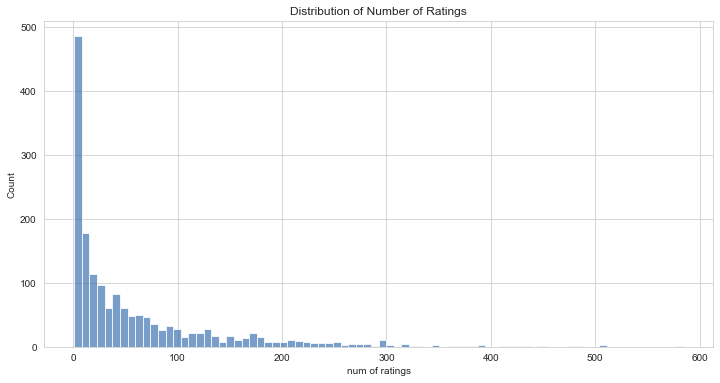

In [8]:
plt.figure(figsize=(12,6))
sns.histplot(data=ratings, x='num of ratings', bins=80, alpha=0.6)
plt.title('Distribution of Number of Ratings')

There is a significantly high amount of movies with only one rating and a decreasing amount of movies as the number of ratings increase. As mentioned before, this will heavily skew the recommendations if we don't take into account the number of ratings.

Text(0.5, 1.0, 'Distribution of Ratings')

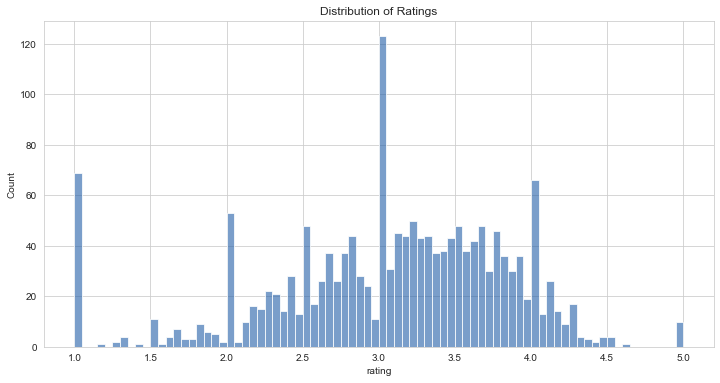

In [9]:
plt.figure(figsize=(12,6))
sns.histplot(data=ratings, x='rating', bins=80, alpha=0.6)
plt.title('Distribution of Ratings')

There are large spikes at each of the whole numbers as either the system only allows you to rate a movie in whole numbers or most people would not go into much more precision than a whole number for this. The majority of the ratings fall in the 3 to 4 range.

Text(0.5, 1.03, 'Number of Ratings vs Rating')

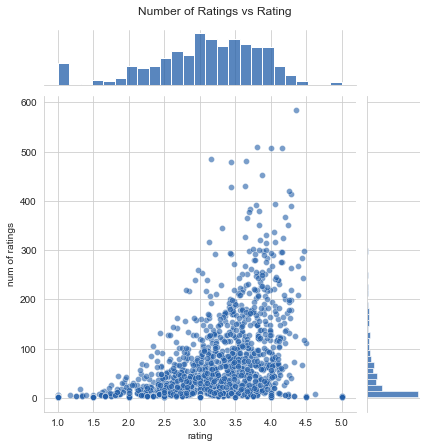

In [10]:
sns.jointplot(data=ratings, x='rating', y='num of ratings', alpha=0.6)
plt.suptitle('Number of Ratings vs Rating', y=1.03)

The higher the rating, the higher the number of ratings. This is likely due to the fact that the better a movie is, the more popular it becomes so therefore more people have watched and rated it.

## Simple Recommender System
I'll start off by building a simple recommender system which will offer generalized movie recommendations based on the movie popularity to find the Top 10 Movies. 

If we sort by rating and sort highest to lowest, there will be a number of movies with very few but high ratings that will be favoured. To avoid this, I'll create a new metric called Score which will be the weighted average of the rating and I'll have a threshold of a minimum amount of ratings to meet before a movie is considered.

In [11]:
# minimum number of ratings received to qualify as a recommendation, used 75th percentile
min_num_ratings = ratings['num of ratings'].quantile(0.75)
print('Minimum number of ratings required per movie: ', min_num_ratings)

Minimum number of ratings required per movie:  80.25


In [12]:
# create new df for qualified movies
qualified_movies = ratings.copy().loc[ratings['num of ratings'] >= min_num_ratings]
qualified_movies.shape

(416, 2)

In [13]:
ratings.shape

(1664, 2)

By only using the 75th percentile of num of ratings, the qualified movies decreased to 416, originally 1664.

In [14]:
total_num_ratings = qualified_movies.loc[:,'num of ratings'].sum()

# takes in df of qualified movies and calculates the score
def movie_score(qualified_movies, total_num_ratings=total_num_ratings):
    
    rating = qualified_movies['rating']
    num_ratings = qualified_movies['num of ratings']
    
    return rating * num_ratings / total_num_ratings

# add new column score and apply the movie_score function
qualified_movies['score'] = qualified_movies.apply(movie_score, axis=1)

# sort highest to lowest score and show top 10
qualified_movies.sort_values(by='score', ascending=False).head(10)

,rating,num of ratings,score
title,,,
Star Wars (1977),4.359589,584,0.035383
Fargo (1996),4.155512,508,0.029337
Return of the Jedi (1983),4.007890,507,0.028239
Contact (1997),3.803536,509,0.026905
Raiders of the Lost Ark (1981),4.252381,420,0.024821
"Godfather, The (1972)",4.283293,413,0.024584
"English Patient, The (1996)",3.656965,481,0.024445
Toy Story (1995),3.878319,452,0.024362
"Silence of the Lambs, The (1991)",4.289744,390,0.023250


Above we have the Top 10 list of movies based solely on rating, filtered by a minimum number of ratings (in the 75th percentile) and weighted by the number of ratings per movie.

## Content-Based Recommender System

Now, I'll build a more specific recommender that will take in a particular movie and output similar results based on ratings. As with before, it will also require a minimum number of ratings in order to qualify.

In [15]:
# create a matrix with movie titles as columns and user_id as index
movie_matrix = df.pivot_table(index='user_id', columns='title', values='rating')
# drop any movies (columns) that do not meeting the minimum number of ratings to qualify
movie_matrix.dropna(axis=1, thresh=min_num_ratings, inplace=True)
movie_matrix.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2 Days in the Valley (1996),2001: A Space Odyssey (1968),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Addams Family Values (1993),"Adventures of Priscilla, Queen of the Desert, The (1994)","African Queen, The (1951)",...,What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),White Squall (1996),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wrong Trousers, The (1993)",Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,5.0,NaN,4.0,NaN,3.0,3.0,NaN,NaN,NaN,...,4.0,5.0,4.0,NaN,NaN,4.0,4.0,5.0,5.0,3.0
2,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# given a movie title, recommends top 10 movies similar to it
def recommender(movie_name):
    
    # each user id and their rating given the chosen movie
    user_ratings = movie_matrix.loc[:, movie_name]
    # delete N/A rows, rows with no ratings
    user_ratings.dropna(inplace=True)
    # calculates correlation between movie matrix and user ratings
    similar_movies = pd.DataFrame(movie_matrix.corrwith(user_ratings), columns=['Correlation'])
    # add num of ratings column
    similar_movies = similar_movies.join(ratings['num of ratings'])
    # filter to movies that meet the minimum num of ratings
    similar_movies = similar_movies.loc[similar_movies['num of ratings'] >= min_num_ratings]
    # drop the given movie from the similar list
    similar_movies.drop(movie_name, axis=0, inplace=True)
    
    # return top 10 movies sorted by highest correlation to given movie
    return similar_movies.sort_values('Correlation', ascending=False).head(10)

# call function on Star Wars
recommender('Star Wars (1977)')

,Correlation,num of ratings
title,,
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115
L.A. Confidential (1997),0.319065,297


Of the movies I recognize from this list, I would agree that they are similar to Star Wars. The top two are in the Star Wars framchise. Raiders of the Lost Ark and Indiana Jones are of similar genres and I believe they might have even had the same director. As we keep going down, I don't see too many similarities in the ones I recognize but they could have just been good and popular movies that were highly rated.    

Next, I will test out the function on two other movies.

In [17]:
recommender('Silence of the Lambs, The (1991)')

,Correlation,num of ratings
title,,
I Know What You Did Last Summer (1997),0.551378,100
Alien: Resurrection (1997),0.408675,124
Basic Instinct (1992),0.403709,101
"Crying Game, The (1992)",0.370926,119
Shine (1996),0.368361,129
"Juror, The (1996)",0.362680,82
Dave (1993),0.358544,180
"Long Kiss Goodnight, The (1996)",0.353039,185
It Happened One Night (1934),0.352233,81


I recognize a couple of horror movie names in this list which are similar to Silence of the Lambs in genre.

In [18]:
recommender('Liar Liar (1997)')

,Correlation,num of ratings
title,,
Batman Forever (1995),0.516968,114
Bean (1997),0.504689,91
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Demolition Man (1993),0.442948,92
Michael (1996),0.442022,119


Lastly, there are some popular recognizable movies here including The Mask which is also a Jim Carrey movie.

## Conclusion
In this project, I have demonstrated building a Simple and a Content-Based Recommender System. The data I used was very similar and the only real feature was rating. Given more features and the use of different algorithms such as Natural Language Processing, a more involved recommender system that took into account more features such as genre, actors, etc. could be built. There is also one more recommender system, Collaborative Filtering that could be used but wasn't.